In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

### Load the Dataset

In [2]:
BASE_DIR = '../dataset/age-gender-recog-dataset'

In [3]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# Convert to dataframe
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print(df.columns)
print(df.head())

Index(['image', 'age', 'gender'], dtype='object')
                                               image  age  gender
0  ../dataset/age-gender-recog-dataset\16_1_2_201...   16       1
1  ../dataset/age-gender-recog-dataset\25_1_1_201...   25       1
2  ../dataset/age-gender-recog-dataset\60_0_3_201...   60       0
3  ../dataset/age-gender-recog-dataset\48_1_0_201...   48       1
4  ../dataset/age-gender-recog-dataset\35_0_0_201...   35       0


In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

### Exploratory Data Analysis

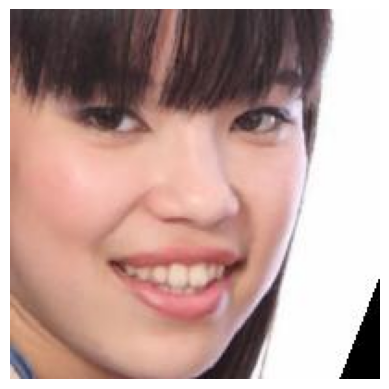

In [6]:
# Display the first image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)
plt.show()

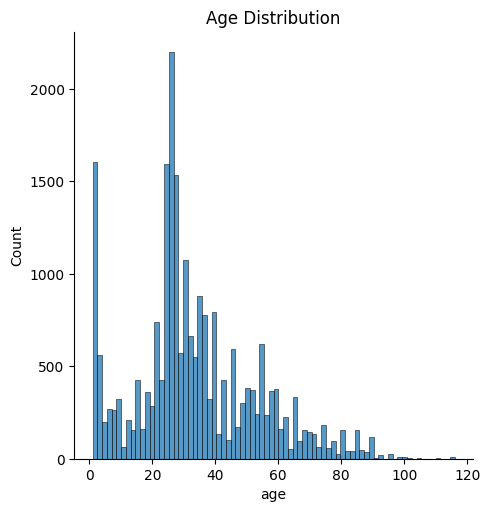

In [7]:
# Plot the age distribution
sns.displot(df['age'], kde=False)
plt.title("Age Distribution")
plt.show()

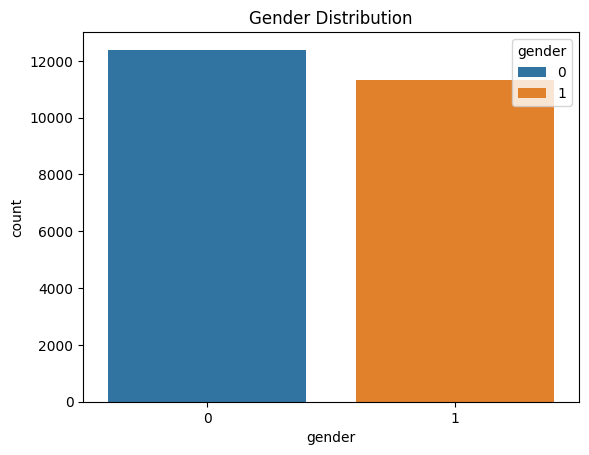

In [8]:
# Plot the gender distribution
sns.countplot(x='gender', data=df, hue='gender', palette=['#1f77b4', '#ff7f0e'])
plt.title("Gender Distribution")
plt.show()

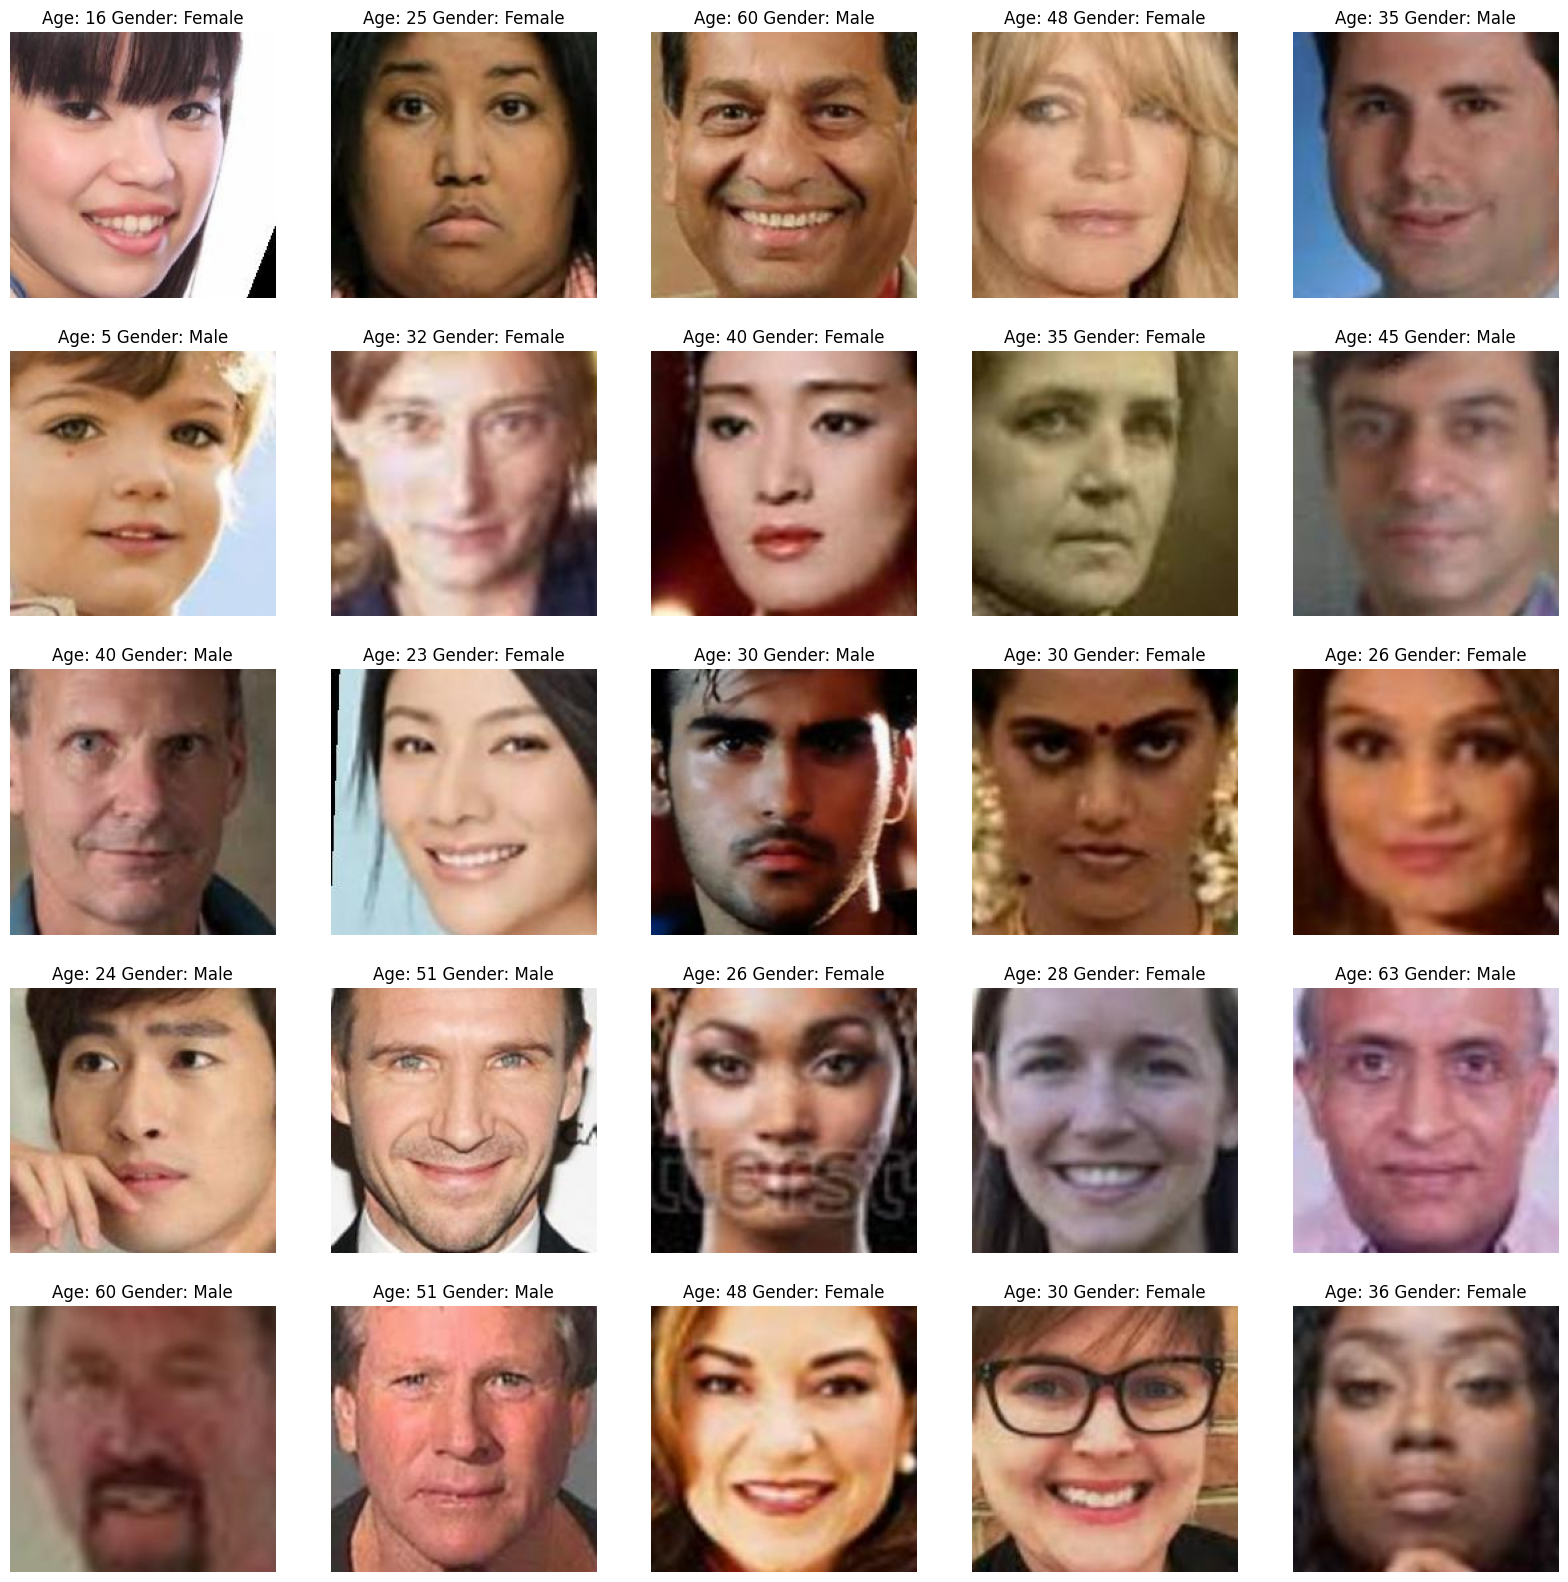

In [9]:
# Display a grid of images with labels
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

# Use plain tuples to access rows
for index, row in enumerate(files.itertuples(index=False, name=None), 1):
    plt.subplot(5, 5, index)
    
    file = row[0]
    age = row[1]
    gender = row[2]
    
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.show()

### Feature Extraction

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS) 
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)  # Adjust if needed for RGB images
    return features

In [11]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
X.shape

(23708, 128, 128, 1)

In [13]:
# normalize the images
X = X/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

### Model Creation

In [16]:
inputs = Input((input_shape))

# convulutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten) # second layer


dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(
    loss={
        'gender_out': 'binary_crossentropy',
        'age_out': 'mse'
    },
    optimizer=Adam(learning_rate=0.0001),  # Start with a lower learning rate
    metrics={
        'gender_out': ['accuracy', Precision(), Recall()],
        'age_out': 'mae'  # Track MAE for the regression task
    }
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Stop early if validation loss stops improving
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),  # Reduce learning rate when a metric has stopped improving
    ModelCheckpoint('../models/best_model.keras', monitor='val_loss', save_best_only=True)  # Save the best model during training
]

In [17]:
# plot the model
# plot_model(model, show_layer_names=True, to_file='model.png')

In [18]:
history = model.fit(
        x=X, 
        y=[y_gender, y_age],
        batch_size=32, 
        epochs=100, 
        validation_split=0.2,
        callbacks=callbacks
    )

Epoch 1/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 95s 155ms/step - age_out_mae: 18.3890 - gender_out_accuracy: 0.5620 - gender_out_precision: 0.5409 - gender_out_recall: 0.4613 - loss: 576.5630 - val_age_out_mae: 13.9542 - val_gender_out_accuracy: 0.7003 - val_gender_out_precision: 0.7068 - val_gender_out_recall: 0.6306 - val_loss: 357.6410 - learning_rate: 1.0000e-04
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 91s 154ms/step - age_out_mae: 13.3241 - gender_out_accuracy: 0.7058 - gender_out_precision: 0.7091 - gender_out_recall: 0.6440 - loss: 295.9569 - val_age_out_mae: 11.1002 - val_gender_out_accuracy: 0.7385 - val_gender_out_precision: 0.6924 - val_gender_out_recall: 0.8086 - val_loss: 229.1080 - learning_rate: 1.0000e-04
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 96s 162ms/step - age_out_mae: 11.4102 - gender_out_accuracy: 0.7489 - gender_out_precision: 0.7530 - gender_out_recall: 0.7087 - loss: 222.5585 - val_age_out_mae: 10.2682 - val_gender_out_accuracy: 0.7704 - val_gender_out_precision: 0.

### Plot the results

<Figure size 640x480 with 0 Axes>

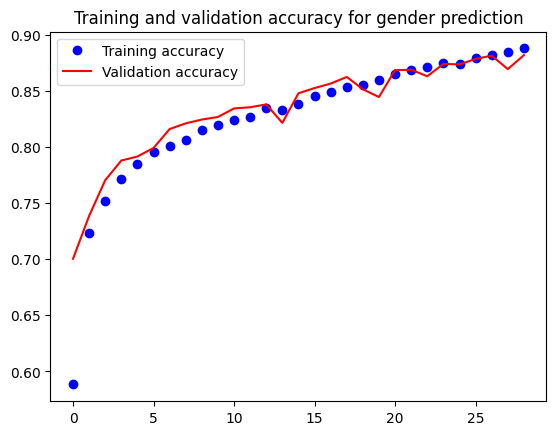

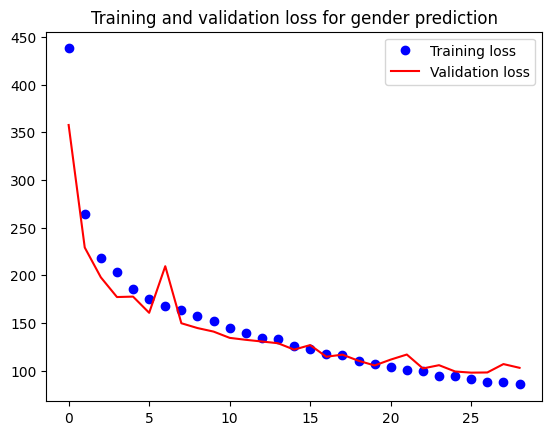

<Figure size 640x480 with 0 Axes>

In [19]:
# Extract accuracy and loss for the gender output
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']

# Look for the correct keys for loss
loss = history.history.get('loss', history.history.get('gender_out_loss'))
val_loss = history.history.get('val_loss', history.history.get('val_gender_out_loss'))

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy for gender prediction')
plt.legend()
plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for gender prediction')
plt.legend()
plt.figure()

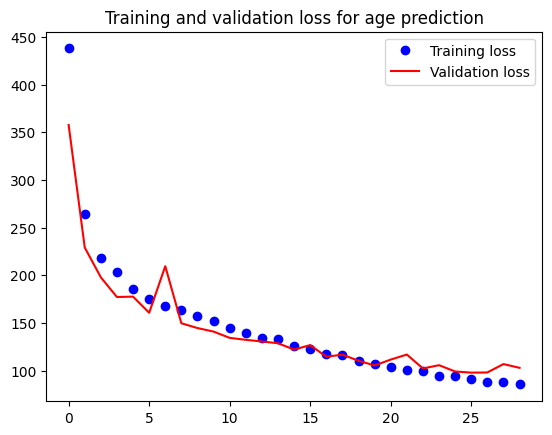

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
# plot results for age
loss = history.history.get('age_out_loss', history.history.get('loss'))
val_loss = history.history.get('val_age_out_loss', history.history.get('val_loss'))

epochs = range(len(loss))

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for age prediction')
plt.legend()
plt.show()
plt.figure()

### Prediction with Test Data

Original Gender:  Male 
Original Age:  18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Gender:  Male 
Predicted Age:  20


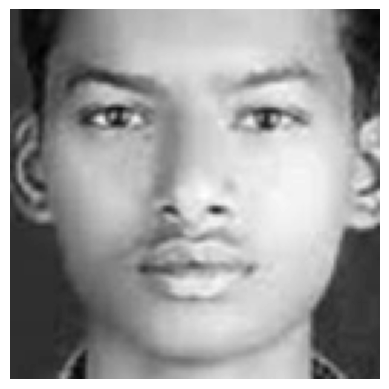

In [23]:
image_index = 15000
print("Original Gender: ", gender_dict[y_gender[image_index]], "\nOriginal Age: ", y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender: ", pred_gender, "\nPredicted Age: ", pred_age)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');